In [1]:
import time
import multiprocessing as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

from nfl_pickem import Pickem

In [2]:
pk = Pickem()
print(pk.file_path)
pk.pull_data()
df = pk.build_schedule()

../nfl-pickem/data/nfl_games.csv
Data successfully pulled!
Seasons 1920-2017: 16007 Games


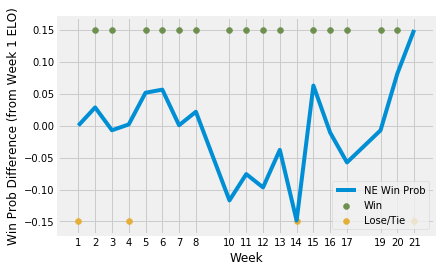

In [3]:
team = 'NE'
cond = df.team == team
plt.plot(df[cond].week.values,
         df[cond].win_prob.values - df[cond].elo_prob1.values,
         label=team+' Win Prob')
plt.scatter(df[cond&(df.result1 > 0.9)].week.values,
            0.3*df[cond&(df.result1 > 0.9)].result1.values - 0.15,
            label='Win', c='C3')
plt.scatter(df[cond&(df.result1 < 0.9)].week.values,
            0.3*df[cond&(df.result1 < 0.9)].result1.values - 0.15,
            label='Lose/Tie', c='C2')
plt.ylabel('Win Prob Difference (from Week 1 ELO)')
plt.xlabel('Week')
plt.xticks(df[cond].week.values,
           df[cond].week.values)
plt.legend(loc='lower right')
plt.show()

## Historical Validation

In [4]:
df = pd.read_csv('results/strategy_analysis.csv')
print(df.shape)

(357, 5)


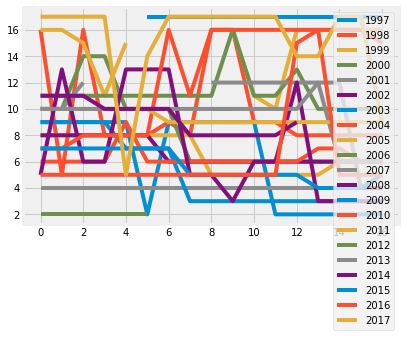

In [5]:
df = df.sort_values(by=['season', 'max_week'])
for season in df.season.unique():
    cond = df.season == season
    plt.plot(df[cond].max_week.values,
             df[cond].elim_week.values,
             label=season)
plt.legend()
plt.show()

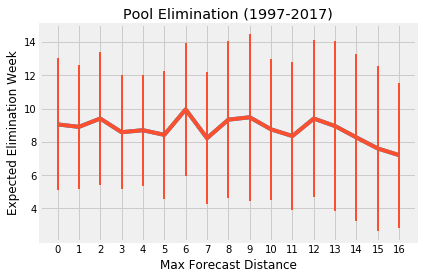

In [6]:
ew = df.groupby('max_week')['elim_week'].agg(['mean', 'std']).reset_index()
plt.plot(ew.max_week.values,
         ew['mean'].values)
plt.errorbar(ew.max_week.values,
             ew['mean'].values,
             yerr=ew['std'].values,
             elinewidth=2)
plt.xticks(ew.max_week.values,
           ew.max_week.values)
plt.xlabel('Max Forecast Distance')
plt.ylabel('Expected Elimination Week')
plt.title('Pool Elimination (1997-2017)')
plt.show()

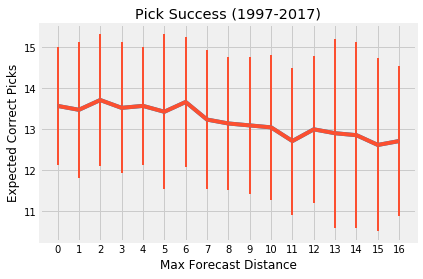

In [7]:
ew = df.groupby('max_week')['correct'].agg(['mean', 'std']).reset_index()
plt.plot(ew.max_week.values,
         ew['mean'].values)
plt.errorbar(ew.max_week.values,
             ew['mean'].values,
             yerr=ew['std'].values,
             elinewidth=2)
plt.xticks(ew.max_week.values,
           ew.max_week.values)
plt.xlabel('Max Forecast Distance')
plt.ylabel('Expected Correct Picks')
plt.title('Pick Success (1997-2017)')
plt.show()

## Checking New Model

In [2]:
pk = Pickem()
print(pk.file_path)
pk.pull_data()

../nfl-pickem/data/nfl_games.csv
Data successfully pulled!
Seasons 1920-2017: 16007 Games


In [3]:
pk.file_path = '../nfl-pickem/data/nfl_elo.csv'
pk.pull_data()
pk.data_.head()

Data successfully pulled!
Seasons 1920-2019: 16541 Games


,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,weekday,week
0,1920-09-26,1920,0,NaN,RII,STP,1503.947,1300.000,0.824651,0.175349,...,NaN,NaN,NaN,NaN,NaN,NaN,48.0,0.0,6,1
1,1920-10-03,1920,0,NaN,DAY,COL,1493.002,1504.908,0.575819,0.424181,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.0,6,2
2,1920-10-03,1920,0,NaN,RII,MUN,1516.108,1478.004,0.644171,0.355829,...,NaN,NaN,NaN,NaN,NaN,NaN,45.0,0.0,6,2
3,1920-10-03,1920,0,NaN,CHI,MUT,1368.333,1300.000,0.682986,0.317014,...,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.0,6,2
4,1920-10-03,1920,0,NaN,CBD,PTQ,1504.688,1300.000,0.825267,0.174733,...,NaN,NaN,NaN,NaN,NaN,NaN,48.0,0.0,6,2


In [4]:
df = pk.data_
print(df.columns)

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'qbelo1_pre', 'qbelo2_pre', 'qb1', 'qb2', 'qb1_value_pre',
       'qb2_value_pre', 'qb1_adj', 'qb2_adj', 'qbelo_prob1', 'qbelo_prob2',
       'qb1_game_value', 'qb2_game_value', 'qb1_value_post', 'qb2_value_post',
       'qbelo1_post', 'qbelo2_post', 'score1', 'score2', 'weekday', 'week'],
      dtype='object')


In [6]:
cols = ['date', 'team1', 'team2', 'elo1_pre',
        'elo2_pre', 'qbelo1_pre', 'qbelo2_pre',
        'qb1_value_pre', 'qb2_value_pre', 'qb1_adj', 'qb2_adj']
df[df.season == 2018][cols].head()

,date,team1,team2,elo1_pre,elo2_pre,qbelo1_pre,qbelo2_pre,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj
16007,2018-09-09,PHI,ATL,1646.786330,1600.640440,1616.495559,1569.750522,157.005121,179.866848,-5.501989,-1.787010
16008,2018-09-09,NYG,JAX,1411.677494,1534.818404,1442.592389,1540.180740,115.058354,170.799467,-7.235753,2.615402
16009,2018-09-09,IND,CIN,1406.904376,1474.615256,1448.789337,1464.650994,191.457132,123.128520,29.502018,-6.388061
16010,2018-09-09,BAL,BUF,1535.270103,1502.216567,1524.717054,1429.214692,146.694073,16.815021,-0.347728,-37.498273
16011,2018-09-09,MIN,SF,1602.219546,1469.474445,1587.222587,1503.183850,160.676407,159.446687,-3.660159,5.672633
